In [111]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [112]:
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [113]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'

train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)

In [114]:
train.corr()

,session_id,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,age_level,user_depth,city_development_index,var_1,is_click
session_id,1.000000,0.009265,-0.245661,-0.253621,-0.040190,-0.192477,0.043984,0.064951,-0.000137,-0.001072,0.023594,-0.011598
user_id,0.009265,1.000000,-0.009227,-0.022056,0.031165,0.015698,0.045024,0.047687,-0.011238,-0.034073,0.057129,-0.004089
campaign_id,-0.245661,-0.009227,1.000000,0.606313,-0.113342,0.222252,-0.028817,-0.063227,-0.023217,0.023914,-0.006588,0.011447
webpage_id,-0.253621,-0.022056,0.606313,1.000000,-0.280598,-0.157034,-0.087625,-0.119225,0.010909,-0.013158,-0.021678,0.041717
product_category_1,-0.040190,0.031165,-0.113342,-0.280598,1.000000,0.107853,0.093174,0.152602,0.002871,0.021651,0.054029,-0.016531
product_category_2,-0.192477,0.015698,0.222252,-0.157034,0.107853,1.000000,0.175898,0.202951,-0.068418,0.127381,0.024321,0.019213
user_group_id,0.043984,0.045024,-0.028817,-0.087625,0.093174,0.175898,1.000000,0.635146,-0.012627,0.043475,0.031456,-0.007815
age_level,0.064951,0.047687,-0.063227,-0.119225,0.152602,0.202951,0.635146,1.000000,0.022386,0.002434,0.121815,-0.009681
user_depth,-0.000137,-0.011238,-0.023217,0.010909,0.002871,-0.068418,-0.012627,0.022386,1.000000,-0.055224,0.105176,-0.000952
city_development_index,-0.001072,-0.034073,0.023914,-0.013158,0.021651,0.127381,0.043475,0.002434,-0.055224,1.000000,-0.129241,-0.005686


In [115]:
is_click_count= len(train[train.is_click==1])

In [116]:
non_click_indices = train[train.is_click==0].index

In [117]:
random_indices = np.random.choice(non_click_indices,is_click_count*10, replace=False)

In [118]:
click_indices = train[train.is_click==1].index

In [119]:
under_sample_indices = np.concatenate([click_indices,random_indices])

In [120]:
under_sample = train.loc[under_sample_indices]

In [121]:
train=under_sample

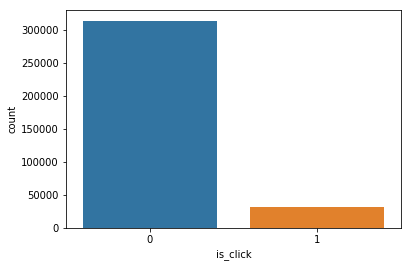

In [122]:
sb.countplot(under_sample.is_click)

In [123]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [124]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [125]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [126]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [127]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [128]:
test.shape

(128858, 14)

In [129]:
train['source']='train'
test['source']='test'
train=train.append(test)
train.info()


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 473499 entries, 38 to 128857
Data columns (total 16 columns):
DateTime                  473499 non-null object
age_level                 454239 non-null float64
campaign_id               473499 non-null int64
city_development_index    345576 non-null float64
gender                    454239 non-null object
is_click                  344641 non-null float64
product                   473499 non-null object
product_category_1        473499 non-null int64
product_category_2        125019 non-null float64
session_id                473499 non-null int64
source                    473499 non-null object
user_depth                454239 non-null float64
user_group_id             454239 non-null float64
user_id                   473499 non-null int64
var_1                     473499 non-null int64
webpage_id                473499 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 61.4+ MB


In [130]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])

In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473499 entries, 0 to 473498
Data columns (total 18 columns):
DateTime                  473499 non-null object
age_level                 454239 non-null float64
campaign_id               473499 non-null int64
city_development_index    345576 non-null float64
gender                    454239 non-null object
is_click                  344641 non-null float64
product                   473499 non-null object
product_category_1        473499 non-null int64
product_category_2        125019 non-null float64
session_id                473499 non-null int64
source                    473499 non-null object
user_depth                454239 non-null float64
user_group_id             454239 non-null float64
user_id                   473499 non-null int64
var_1                     473499 non-null int64
webpage_id                473499 non-null int64
interest                  82513 non-null float64
view                      381853 non-null float64
dtypes

In [132]:
#t_click1=train[train.is_click==1]
#train=train.append(t_click1)
#train=train.append(t_click1)

In [133]:
train.isnull().sum()

DateTime                       0
age_level                  19260
campaign_id                    0
city_development_index    127923
gender                     19260
is_click                  128858
product                        0
product_category_1             0
product_category_2        348480
session_id                     0
source                         0
user_depth                 19260
user_group_id              19260
user_id                        0
var_1                          0
webpage_id                     0
interest                  390986
view                       91646
dtype: int64

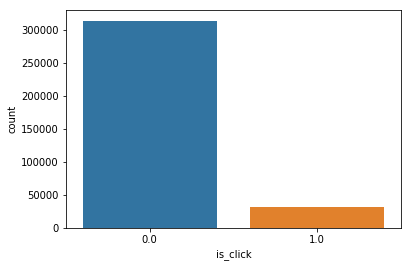

In [134]:
sb.countplot(train.is_click)

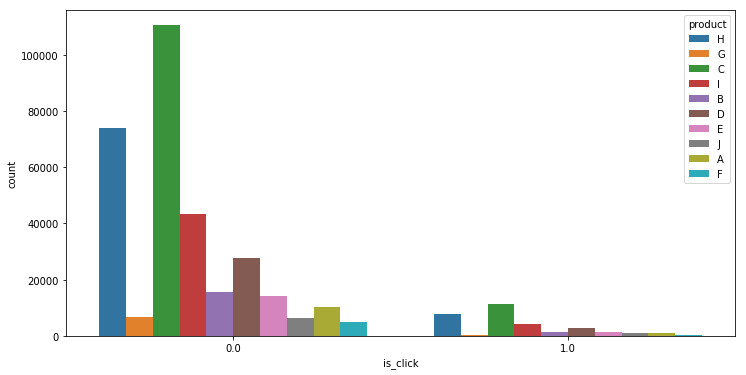

In [135]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='product', data=train)

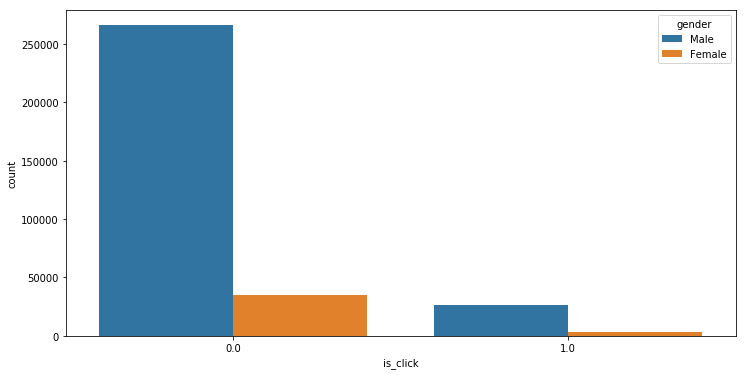

In [136]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='gender', data=train)

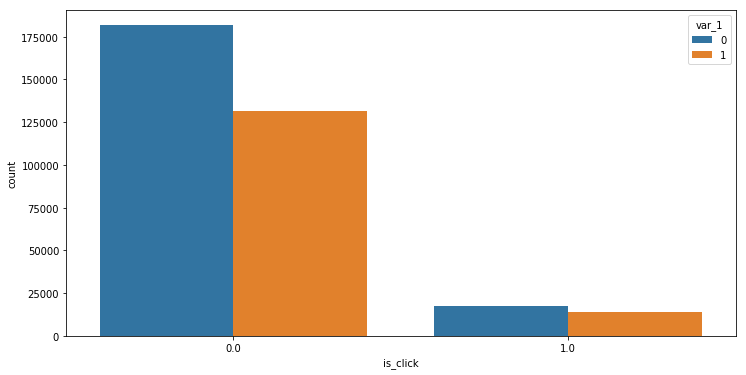

In [137]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='var_1', data=train)

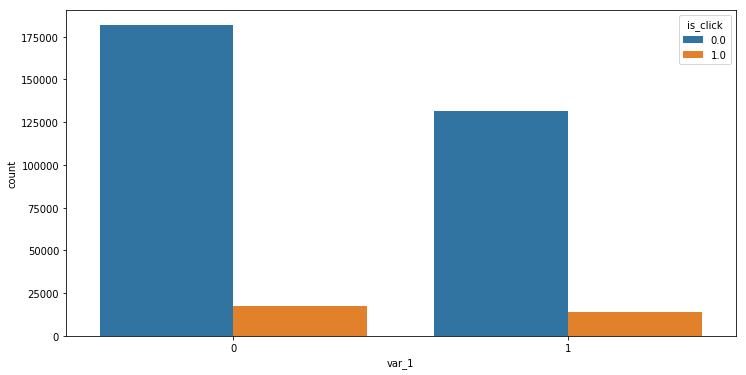

In [138]:
plt.figure(figsize=(12,6))
sb.countplot(x='var_1', hue='is_click', data=train)

In [139]:
train_label= train.is_click


In [140]:
train.gender=train.gender.fillna('Unknown')

In [141]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [142]:
train.age_level= train.age_level.fillna(method='pad')

In [143]:
train.user_depth= train.user_depth.fillna(method='pad')

In [144]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [145]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)

In [146]:
train=pd.get_dummies(train,columns=['gender','product'])

In [147]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2017-07-02 00:05,2.0,359520,NaN,1.0,3,NaN,489923,train,2.0,...,0,0,0,0,0,0,0,1,0,0
1,2017-07-02 00:07,3.0,98970,4.0,1.0,4,NaN,419802,train,3.0,...,0,0,0,0,0,0,1,0,0,0
2,2017-07-02 00:08,3.0,359520,4.0,1.0,4,NaN,145098,train,3.0,...,0,0,1,0,0,0,0,0,0,0
3,2017-07-02 00:13,2.0,405490,4.0,1.0,3,NaN,102183,train,3.0,...,0,0,1,0,0,0,0,0,0,0
4,2017-07-02 00:13,2.0,405490,3.0,1.0,3,NaN,72843,train,3.0,...,0,0,1,0,0,0,0,0,0,0


In [148]:
train= train.drop(['DateTime','user_id','product_category_2','session_id'],axis=1)

In [149]:
train.head()

,age_level,campaign_id,city_development_index,is_click,product_category_1,source,user_depth,user_group_id,var_1,webpage_id,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2.0,359520,NaN,1.0,3,train,2.0,2.0,0,13787,...,0,0,0,0,0,0,0,1,0,0
1,3.0,98970,4.0,1.0,4,train,3.0,9.0,1,6970,...,0,0,0,0,0,0,1,0,0,0
2,3.0,359520,4.0,1.0,4,train,3.0,3.0,0,13787,...,0,0,1,0,0,0,0,0,0,0
3,2.0,405490,4.0,1.0,3,train,3.0,2.0,0,60305,...,0,0,1,0,0,0,0,0,0,0
4,2.0,405490,3.0,1.0,3,train,3.0,2.0,1,60305,...,0,0,1,0,0,0,0,0,0,0


In [150]:
test=train[train.source=='test']
train=train[train.source=='train']


In [151]:
train.drop('source',axis=1,inplace=True)

In [152]:
test.drop('source',axis=1,inplace=True)

In [153]:
train_label=train.is_click

In [154]:
train=train[~(train.city_development_index.isna())]
train.isna().sum()

age_level                 0
campaign_id               0
city_development_index    0
is_click                  0
product_category_1        0
user_depth                0
user_group_id             0
var_1                     0
webpage_id                0
interest                  0
view                      0
gender_Female             0
gender_Male               0
gender_Unknown            0
product_A                 0
product_B                 0
product_C                 0
product_D                 0
product_E                 0
product_F                 0
product_G                 0
product_H                 0
product_I                 0
product_J                 0
dtype: int64

In [155]:
x=train.drop("is_click",axis=1)

In [156]:
y=train["is_click"]

In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=22)

In [158]:
from sklearn.linear_model import LogisticRegression
logmod=LogisticRegression()

In [159]:
logmod.fit(x_train,y_train)
pred=logmod.predict(x_test)

C:\Amrendra\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
from sklearn.metrics import classification_report
classification_report(y_test,pred)

C:\Amrendra\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Amrendra\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Amrendra\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'              precision    recall  f1-score   support\n\n         0.0       0.91      1.00      0.95     93933\n         1.0       0.00      0.00      0.00      9459\n\n   micro avg       0.91      0.91      0.91    103392\n   macro avg       0.45      0.50      0.48    103392\nweighted avg       0.83      0.91      0.86    103392\n'

In [161]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[93933,     0],
       [ 9459,     0]], dtype=int64)

In [162]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.9085132311977716

In [163]:
x_test=test.drop("is_click",axis=1)
test_pred=logmod.predict(x_test)
prediction=pd.Series(test_pred.tolist()).astype(int)

In [164]:
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/predictionulgst.csv')

In [165]:
#test.shape